In [1]:
# Counting sounds in audio

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os
import sys
import collections
import numpy as np

sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import frequency
from engaged.features import wave
from engaged.features import features
import cPickle as pickle
where_to_save = '/home/michael/projects/engaged_hackathon_data/detection/training_data/'

In [2]:
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files/'
dataset_csv = csv.reader(open(base_path + 'urban_sounds_labels.csv'))

annotations = []  # list of all class info

def try_number(s):
    """Converts s to float if possible, else leaves as is"""
    try:
        return float(s)
    except ValueError:
        return s

# I'm basically reinventing pandas here - very silly
for count, line in enumerate(dataset_csv):
    if count == 0:
        header = line
        continue
        
    annotation = {label:try_number(item) for label, item in zip(header, line)}    
    annotation['length'] = \
        annotation['LabelEndTime_Seconds'] - annotation['LabelStartTime_Seconds']
    annotation['Label'] = annotation['Label'].strip().lower()
    annotations.append(annotation)

In [3]:
spectrogram_parameters = {
    'nfft': 1024,
    'window_width': 0.03,
    'overlap': 0.01
    }

In [4]:
# group annotations by filename
file_annotations = collections.defaultdict(list)
for annotation in annotations:
    file_annotations[annotation['Filename']].append(annotation)

In [150]:
# The audio files are too big to load in all at once, so we will loop over them and process them one at a time
# loop through the csv file - (could be better to only do this once at the top of the notebook)



bird_snippets = {}
non_bird_snippets = {}

# from skimage.util import view_as_blocks
# slice_height = 16
# def vertical_slice(array, slice_height):
#     """
#     Slice up an array in the vertical direction
#     """
#     new_height = slice_height * np.floor(array.shape[0] / float(slice_height))
#     array = features.force_spectrogram_length(array.T, new_height).T

#     view = view_as_blocks(array, (slice_height, array.shape[1]))
# #     print "Shape is ", view.shape
#     if view.shape[0] > 0:
#         return view.reshape(view.shape[0], -1)
#     else:
#         return np.array([])
    

def list_of_snippets_to_np(snippet_list):
    """
    Reshapes a list of snippets to a single numpy array
    """
    slices = [snip.series for snip in snippet_list]
    
    if slices:
        return np.vstack(slices)
    else:
        return np.array([])
        
count = 0
for filename, annotations in file_annotations.iteritems():
    
    # load in the audio signal and the annotations
    wav = wave.LabelledWave()
    wav.load_from_wav(base_path + '25_Random/' + filename)
    wav.set_annotations(annotations)
    
    # convert to a spectrogram and remove the median
    spec = wave.LabelledSpectrogram()
    spec.from_wave(wav, **spectrogram_parameters)    
    spec.series -= np.median(spec.series, axis=0)
    
    # extract bird and non-bird from the spectrogram
    bird_snippets[filename] = spec.snippets_with_labels('bird')
    non_bird_snippets[filename] = spec.snippets_except_labels('bird')
    
    # combine each list
    bird_slices_np = list_of_snippets_to_np(bird_snippets[filename])
    non_bird_slices_np = list_of_snippets_to_np(non_bird_snippets[filename])
    
    # possibly save these to disk if memory becomes tight...
    fname = where_to_save + filename.replace('.wav', '_bird_snippets.pkl')
    pickle.dump(bird_slices_np, open(fname, 'w'))
    
    fname = where_to_save + filename.replace('.wav', '_non_bird_snippets.pkl')
    pickle.dump(non_bird_slices_np, open(fname, 'w'), protocol=pickle.HIGHEST_PROTOCOL)
    
    # keep us updated about how well we are doing
    print "Done %d of %d" % (count, len(file_annotations))
    count += 1

Done 0 of 362
Done 1 of 362
Done 2 of 362
Done 3 of 362
Done 4 of 362
Done 5 of 362
Done 6 of 362
Done 7 of 362
Done 8 of 362
Done 9 of 362
Done 10 of 362
Done 11 of 362
Done 12 of 362
Done 13 of 362
Done 14 of 362
Done 15 of 362
Done 16 of 362
Done 17 of 362
Done 18 of 362
Done 19 of 362
Done 20 of 362
Done 21 of 362
Done 22 of 362
Done 23 of 362
Done 24 of 362
Done 25 of 362
Done 26 of 362
Done 27 of 362
Done 28 of 362
Done 29 of 362
Done 30 of 362
Done 31 of 362
Done 32 of 362
Done 33 of 362
Done 34 of 362
Done 35 of 362
Done 36 of 362
Done 37 of 362
Done 38 of 362
Done 39 of 362
Done 40 of 362
Done 41 of 362
Done 42 of 362
Done 43 of 362
Done 44 of 362
Done 45 of 362
Done 46 of 362
Done 47 of 362
Done 48 of 362
Done 49 of 362
Done 50 of 362
Done 51 of 362
Done 52 of 362
Done 53 of 362
Done 54 of 362
Done 55 of 362
Done 56 of 362
Done 57 of 362
Done 58 of 362
Done 59 of 362
Done 60 of 362
Done 61 of 362
Done 62 of 362
Done 63 of 362
Done 64 of 362
Done 65 of 362
Done 66 of 362
Done 

In [9]:
# do a train/test split at the filename level
from sklearn.cross_validation import train_test_split
train_filenames, test_filenames = train_test_split(file_annotations.keys(), random_state=10)
print len(train_filenames), len(test_filenames)

271 91


In [30]:
# now load in training data for bird and non-bird
all_birds, all_non_birds = [], []

def load_data(filenames, balance_classes=True, max_instances=None):
    """
    Loads precomputed data for a list of filenames
    """
    for filename in filenames:

        # load bird training instance
        fname = where_to_save + filename.replace('.wav', '_bird_snippets.pkl')
        all_birds_np = pickle.load(open(fname))
        if all_birds_np.shape[0] > 0:
            all_birds.append(all_birds_np)

        # load non-bird training instance
        fname = where_to_save + filename.replace('.wav', '_non_bird_snippets.pkl')
        non_birds_np = pickle.load(open(fname))
        
        # resample 1%...
        idxs = np.random.choice(
            non_birds_np.shape[0], 0.1*non_birds_np.shape[0], replace=False)
        
        all_non_birds.append(non_birds_np[idxs, :])
        
    # convert to numpy
    all_birds_np = np.vstack(all_birds)
    non_birds_np = np.vstack(all_non_birds)
    
    # balance classes
    if balance_classes:
        num_train_examples = min(
            max_instances, all_birds_np.shape[0], non_birds_np.shape[0])
        
        bird_idxs = np.random.choice(
            all_birds_np.shape[0], num_train_examples, replace=False)
        non_bird_idxs = np.random.choice(
            non_birds_np.shape[0], num_train_examples, replace=False)
    
        all_birds_np = all_birds_np[bird_idxs]
        non_birds_np = non_birds_np[non_bird_idxs]
        
    X = np.vstack((all_birds_np, non_birds_np))
    Y = np.hstack((all_birds_np.shape[0] * [1], non_birds_np.shape[0] * [0]))
    
    print X.shape, Y.shape
    assert X.shape[0] == Y.shape[0]
    
    return X, Y
  
X_train, Y_train = load_data(train_filenames, max_instances=40000)

print X_train.shape, Y_train.shape

(80000, 512) (80000,)
(80000, 512) (80000,)


In [31]:
# now train a model 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(50, n_jobs = 8)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

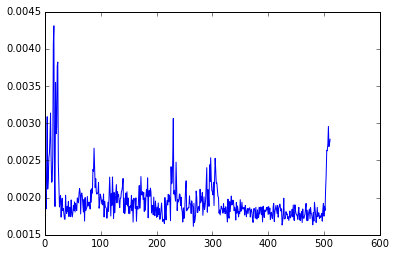

In [32]:
plt.plot(rf.feature_importances_)

In [33]:
# now test on the test files...
X_test, Y_test = load_data(train_filenames, balance_classes=False)

(459310, 512) (459310,)


In [34]:
print X_test.shape, Y_test.shape
print float(Y_test.sum()) / Y_test.shape[0]

(459310, 512) (459310,)
0.321586727918


In [37]:
Y_pred = rf.predict(X_test)

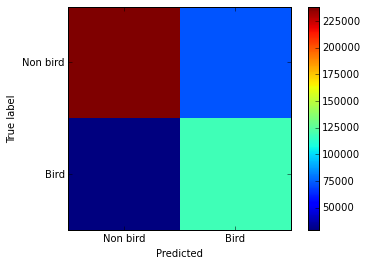

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
ax = plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks([0, 1])
plt.gca().set_yticks([0, 1])
plt.gca().set_xticklabels(['Non bird', 'Bird'])
plt.gca().set_yticklabels(['Non bird', 'Bird'])
plt.ylabel('True label')
plt.xlabel('Predicted')

In [39]:
print cm

[[238546  73056]
 [ 29150 118558]]


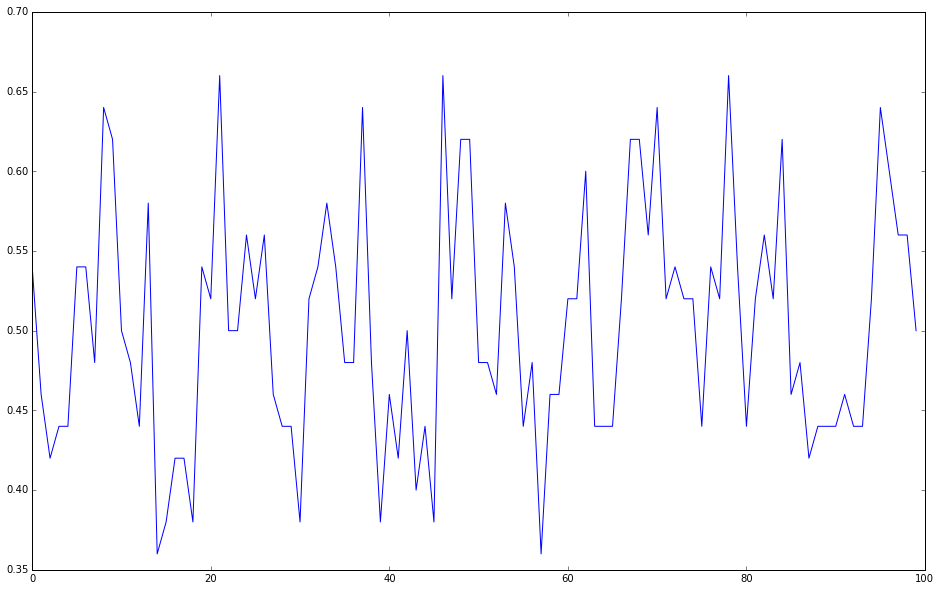

In [47]:
# test on a full test file
filename = test_filenames[2]

wav = wave.LabelledWave()
wav.load_from_wav(base_path + '25_Random/' + filename)
wav.set_annotations(file_annotations[filename])

for ann in file_annotations[filename]:
    if ann['Label'] == 'bird':
        print 2

spec = wave.LabelledSpectrogram()
spec.from_wave(wav, **spectrogram_parameters)    
spec.series -= np.median(spec.series, axis=0)

# make the predictions
wav_pred = rf.predict_proba(spec.series)

plt.figure(figsize=(16, 10))
plt.plot(wav_pred[:100, 0])


44 braking
282 braking
348 braking
357 braking


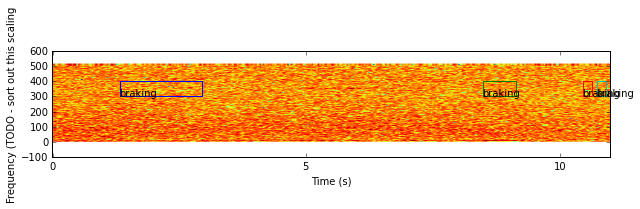

In [27]:
fig = plt.figure(1, figsize=(10, 6))
# ax1 = plt.axes([0.05, 0.7, 0.9, 0.25])
# ax0 = plt.axes([0.05, 0.05, 0.9, 0.60])

# plt.imshow()
spec.plot_annotations(max_time=11, ax=plt.gca())
plt.plot()